In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pvi.models import SparseGaussianProcessRegression
from pvi.clients import Client
from pvi.distributions import MultivariateGaussianDistributionWithZ
from pvi.distributions import MultivariateGaussianFactorWithZ
from pvi.models.sgp.kernels import RBFKernel

import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
import tqdm.auto as tqdm

from torch import nn

%matplotlib inline
torch.set_default_dtype(torch.float64)

# Set up data and helper functions

In [3]:
x = np.linspace(-1, 1, 50)
y = 2 * np.sin(5*x) + 3 * np.abs(x) * np.random.rand(len(x))

x = torch.tensor(x).unsqueeze(1)
y = torch.tensor(y).unsqueeze(1)

In [4]:
def plot_data(x, y):
    plt.figure()
    plt.grid(visible=True)
    plt.scatter(x, y)
    plt.show()
    
def plot_results(x, y, model, q):
    pp = model(x, q)
    mean = pp.mean.detach()
    std = pp.variance.detach() ** 0.5
    
    samples = pp.sample((20,))
    
    plt.figure()
    plt.grid(visible=True)
    
    for sample in samples:
        plt.plot(x, sample, color='k', alpha=.1)
        
    plt.plot(x.squeeze(-1), mean)
    plt.fill_between(x.squeeze(-1), mean-1.96*std, mean+1.96*std, alpha=.25)
    plt.scatter(x, y)
    plt.show()
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure()
    plt.grid(visible=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()
    
data = {
    "x": x,
    "y": y,
}

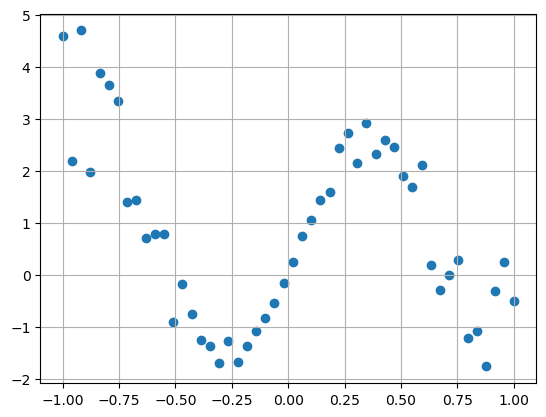

In [5]:
plot_data(x, y)

# Construct SGP model

In [6]:
model_config = {
    "D": 1,
    "kernel_params": {
        "train_hypers": True,
        #Added following line as is in base case
        "ard_num_dims": None,
    }
}

model_hyperparameters = {
    "outputsigma": .1,
    "outputscale": 1.,
    "lengthscale": .5,
}

model = SparseGaussianProcessRegression(hyperparameters=model_hyperparameters, config=model_config, train_sigma=True)


inducing_locations = x[::10].clone()
num_inducing = len(inducing_locations)
q = MultivariateGaussianDistributionWithZ(
    nat_params={
        "np1": torch.zeros(num_inducing),
        "np2": -0.5 * torch.eye(num_inducing)
    },
    inducing_locations=inducing_locations,
    train_inducing=False,
)

{'train_hypers': True, 'ard_num_dims': None}


In [7]:
model.hyperparameters

{'outputscale': 1.0, 'lengthscale': 0.5, 'outputsigma': 0.1}

In [8]:
q.inducing_locations

tensor([[-1.0000],
        [-0.5918],
        [-0.1837],
        [ 0.2245],
        [ 0.6327]])

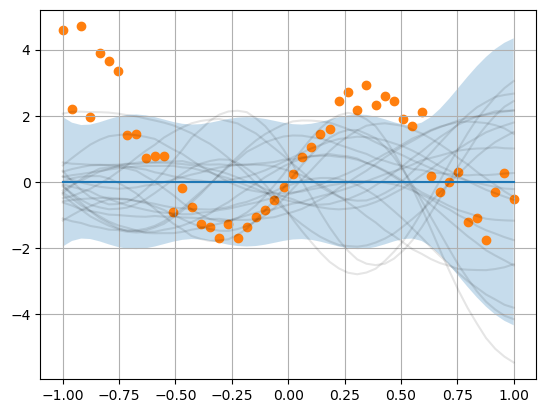

In [9]:
plot_results(x, y, model, q)

# Fit data

In [10]:
t = MultivariateGaussianFactorWithZ(
    nat_params = {
        "np1": torch.tensor([0.] * num_inducing),
        "np2": torch.tensor([0.] * num_inducing).diag_embed()
    },
    inducing_locations=inducing_locations,
    train_inducing=False,
)

In [11]:
print(t.nat_params)

{'np1': tensor([0., 0., 0., 0., 0.]), 'np2': tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])}


In [12]:
client_config = {
    "epochs": 200,
    "optimiser_params": {"lr": 1e-1},
    "batch_size": 50,
    "train_model": True,
}

# Construct client.
client = Client(data=data, model=model, t=t, config=client_config)

## Without optimising model (hyper-)parameters

In [13]:
q_new, t_new = client.update_q(q)

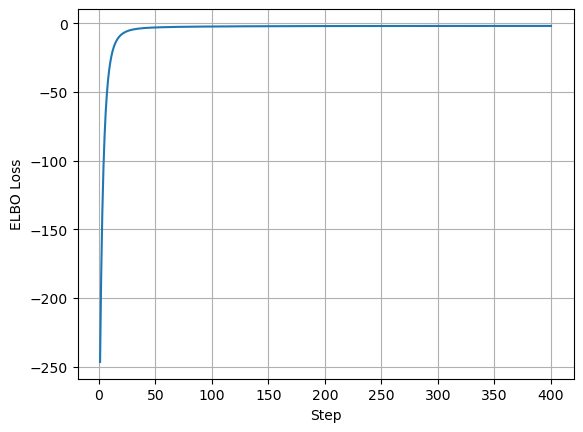

In [14]:
plot_training(client.log["training_curves"][0]["elbo"])

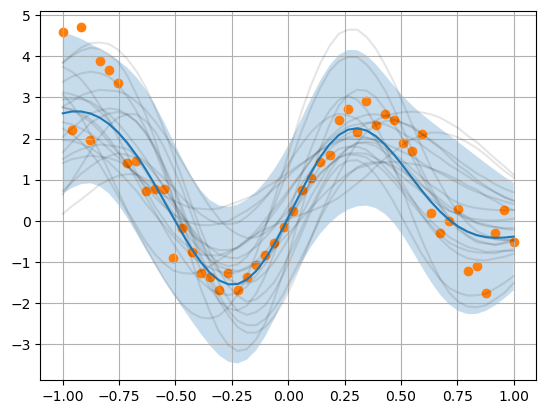

In [15]:
plot_results(x, y, client.model, q_new)